<a href="https://colab.research.google.com/github/soodeh-nilforoushan/Recurrent-Neural-Network/blob/main/8_LSTM_Nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install -q tensorflow
import tensorflow as tf
print(tf.__version__)

2.12.0


In [39]:
from tensorflow.keras.layers import Input, Dense, Flatten, SimpleRNN, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
#make the original data set + add some noise
series=np.sin((0.1*np.arange(400))**2)

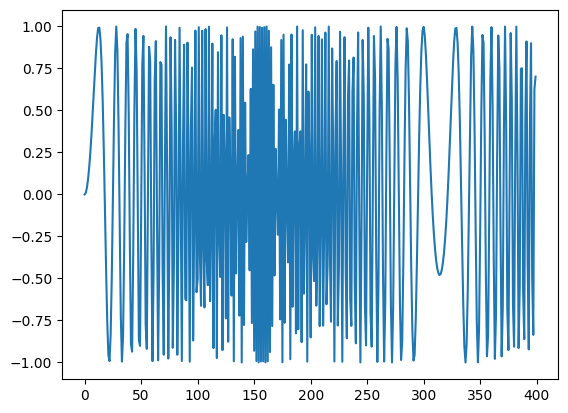

In [41]:
#plot it
plt.plot(series)
plt.show()

In [42]:
#build the dataset
#lets see if we can use T past values to predict the next values
T=10
D=1
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T) #now the data sould be N*T*D
Y=np.array(Y)
N=len(X)
print("X.shape", X.shape,"Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390,)


In [43]:
#try autoregressive linear model
i=Input(shape=(T,))
x=Dense(1)(i)
model=Model(i,x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1),
)
#train the RNN
r=model.fit(
    X[:-N//2],Y[:-N//2], #You don't want to split up your data randomly, let's say using the scikit learn function. Train test split. This wouldn't make sense because a real forecasting model has to predict the future. It can't train on points within that future.Thus, our model trains only on the first half of the data set and validates on the second half. Now since sine w
    epochs=80,
    validation_data=(X[-N//2:],Y[-N//2:]),
            )

Epoch 1/80
7/7 [==============================] - 1s 28ms/step - loss: 1.3394 - val_loss: 1.6088
Epoch 2/80
7/7 [==============================] - 0s 9ms/step - loss: 1.3163 - val_loss: 1.5878
Epoch 3/80
7/7 [==============================] - 0s 10ms/step - loss: 1.2941 - val_loss: 1.5670
Epoch 4/80
7/7 [==============================] - 0s 10ms/step - loss: 1.2727 - val_loss: 1.5466
Epoch 5/80
7/7 [==============================] - 0s 17ms/step - loss: 1.2538 - val_loss: 1.5242
Epoch 6/80
7/7 [==============================] - 0s 25ms/step - loss: 1.2337 - val_loss: 1.5057
Epoch 7/80
7/7 [==============================] - 0s 11ms/step - loss: 1.2156 - val_loss: 1.4887
Epoch 8/80
7/7 [==============================] - 0s 14ms/step - loss: 1.1980 - val_loss: 1.4734
Epoch 9/80
7/7 [==============================] - 0s 33ms/step - loss: 1.1816 - val_loss: 1.4564
Epoch 10/80
7/7 [==============================] - 0s 14ms/step - loss: 1.1642 - val_loss: 1.4383
Epoch 11/80
7/7 [=============

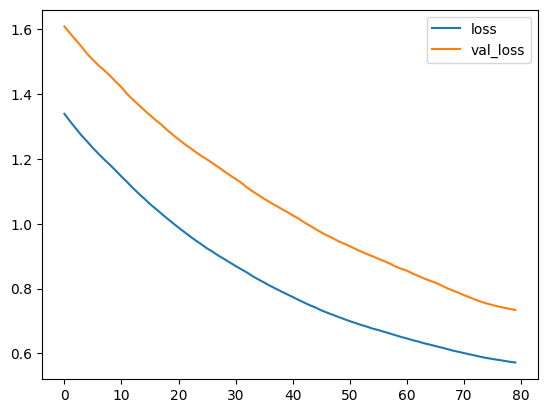

In [44]:
import matplotlib.pyplot as plt
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

13/13 [==============================] - 0s 2ms/step
(390, 1)


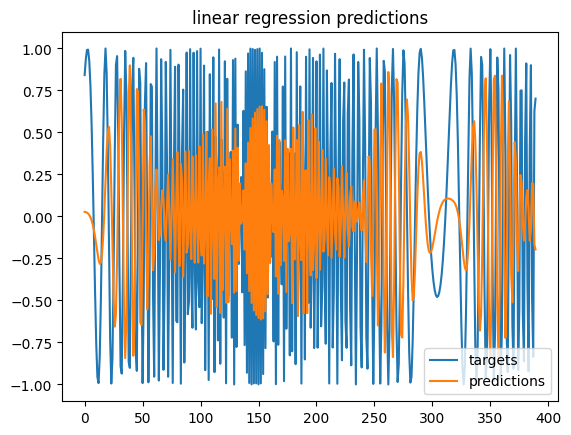

In [45]:
#one step forcaset using true tragets
# note: even the one-step forecast fails badly
outputs=model.predict(X)

print(outputs.shape)
predictions=outputs[:,0] # the first half of x is our train set and the second half of x is our test set.

plt.plot(Y,label="targets")
plt.plot(predictions, label="predictions")
plt.title("linear regression predictions")
plt.legend()
plt.show()

So as you can see, it doesn't do very well. It doesn't even get the values in the right range. Knowing this, we can deduce that the multi step forecast is going to be even worse.



1/1 [==============================] - 0s 24ms/step


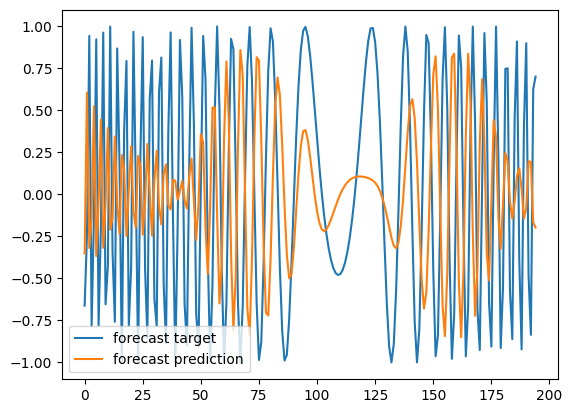

In [46]:
#ONE STEP forecast using true targets
#this is the code we had before - it does the same thing

validation_target=Y[-N//2:]
validation_predictions=[]

#index of first validation input
i = -N//2

while len(validation_predictions)<len(validation_target):
  p = model.predict(X[i].reshape(1,-1))[0,0]
  i+=1

  #update the predictions list
  validation_predictions.append(p)
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()

1/1 [==============================] - 0s 22ms/step


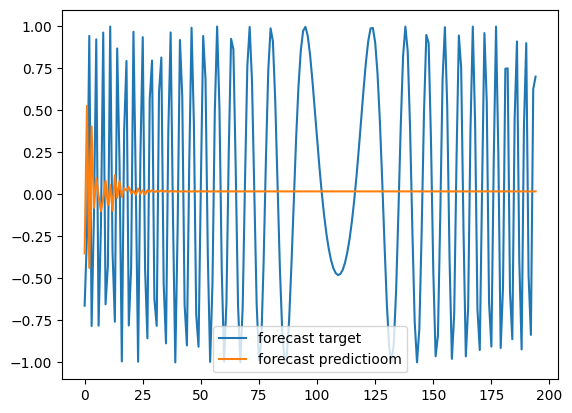

In [47]:
#multistep forcast
validation_target=Y[-N//2:]
validation_predictions=[]

#But the problem was we shouldn't have been using the true input data to predict future values of the time series
#last train input
last_x=X[-N//2]

while len(validation_predictions)<len(validation_target):
  p=model.predict(last_x.reshape(1,-1))[0,0]

  #update the predictions list
  validation_predictions.append(p)

  #make the new input
  #shift or role by minus one means shift everything one spot to the left.
  last_x=np.roll(last_x,-1)
  #The leftmost value ends up looping back around to the right, but we replace it anyway with P. The latest prediction.
  last_x[-1]=p
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast predictioom")
plt.legend()

The linear model does a terrible forecast.

In [48]:
### now try RNN/LSTM model
X=X.reshape(-1,T,1) #make it N * T *D

#make the RNN
i=Input(shape=(T,D))
# x=SimpleRNN(10)(i)
x=LSTM(10)(i)
x= Dense(1)(x)
model=Model(i,x)
model.compile(
    loss="mse",
    optimizer=Adam(lr=0.05),)

#train the RNN
r=model.fit(
    X[:-N//2], Y[:-N//2],
    batch_size=32,
    epochs=200,
    validation_data=(X[-N//2:], Y[-N//2:])
)

Epoch 1/200
7/7 [==============================] - 3s 95ms/step - loss: 0.5360 - val_loss: 0.4718
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 0.5332 - val_loss: 0.4715
Epoch 3/200
7/7 [==============================] - 0s 13ms/step - loss: 0.5314 - val_loss: 0.4716
Epoch 4/200
7/7 [==============================] - 0s 14ms/step - loss: 0.5292 - val_loss: 0.4717
Epoch 5/200
7/7 [==============================] - 0s 14ms/step - loss: 0.5272 - val_loss: 0.4721
Epoch 6/200
7/7 [==============================] - 0s 14ms/step - loss: 0.5257 - val_loss: 0.4728
Epoch 7/200
7/7 [==============================] - 0s 13ms/step - loss: 0.5239 - val_loss: 0.4726
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5223 - val_loss: 0.4726
Epoch 9/200
7/7 [==============================] - 0s 13ms/step - loss: 0.5208 - val_loss: 0.4725
Epoch 10/200
7/7 [==============================] - 0s 13ms/step - loss: 0.5194 - val_loss: 0.4727
Epoch 11/200
7/7 [=

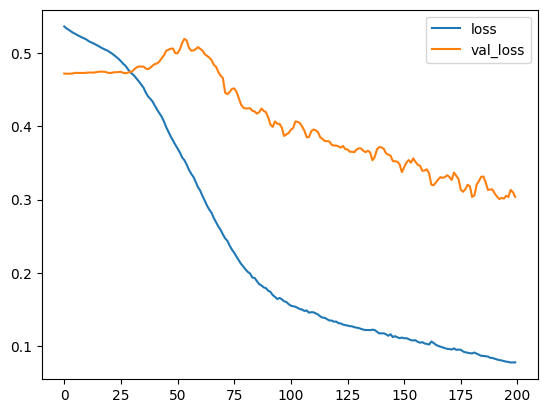

In [49]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

13/13 [==============================] - 1s 3ms/step
(390, 1)


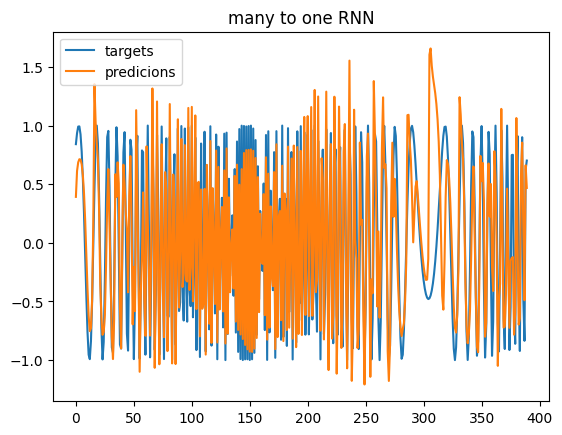

In [51]:
outputs=model.predict(X)
print(outputs.shape)
predictions=outputs[:,0]

plt.plot(Y, label="targets")
plt.plot(predictions, label="predicions")
plt.title("many to one RNN")
plt.legend()
plt.show()

this does a much better job.

1/1 [==============================] - 0s 33ms/step


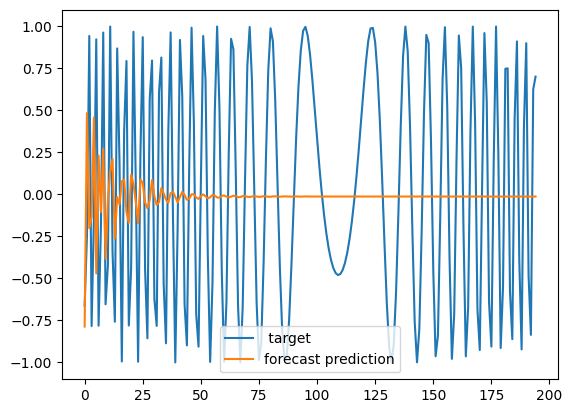

In [53]:
#multistep forcast
forecast=[]
input_=X[-N//2]

while len(forecast)<len(Y[-N//2:]):
  # reshape the input to N * T * D
  p=model.predict(input_.reshape(1,T, 1))[0,0]
  forecast.append(p)

  #make a new input with latest forecast
  input_=np.roll(input_, -1)
  input_[-1]= p

plt.plot(Y[-N//2:], label=" target")
plt.plot(forecast, label="forecast prediction")
plt.legend()
plt.show()

As you can see, this doesn't look that good.

But at least at the beginning, the model appears to capture the frequency quite well.

It doesn't know that in the second half the signal slows down.

Lstms are better than RNNs at finding long term dependencies, but this doesn't mean that lstms are simply better at everything. It doesn't mean that Lstms are magic.

Now, although Lstms are good at finding long term dependencies, it's important to realize that this fact doesn't hold true for arbitrarily long term dependencies. There is a point where even lstms forget. Of course that point is further than the simple rnn, but it exists nonetheless. So avoid absolute generalizations, first of all.

And second, note that this dataset doesn't really have any long term dependencies, at least for the time span of the dataset as it exists right now.

Data from very far in the past isn't really going to help predict future values.

So in fact it makes sense that there's no real advantage to using Lstms for this problem.

